In [1]:
# imports
import torch
import PyTorchDIA_CCD
import numpy as np
from astropy.io import fits
from astropy.stats import mad_std
import os
from scipy.signal import convolve2d as conv
from skimage.feature import register_translation
from scipy.ndimage import shift
from ccdproc import cosmicray_lacosmic as lacosmic
import matplotlib.pyplot as plt
%matplotlib inline

PyTorch version: 1.6.0


In [2]:
## Specify a few useful functions ##
def convert_to_tensor(data):
    # converts np array to F32 tensor
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

## save results
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

## zero-pad
def extend_image_hw(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + kernel_size - 1,
                             np.shape(image)[1] + kernel_size - 1))
    hwidth = np.int((kernel_size - 1) / 2)
    image_extended[hwidth:image_extended.shape[0]-hwidth,
                   hwidth:image_extended.shape[1]-hwidth] = np.array(image, float)
    return image_extended

## negative log-likelihood
# EMCCD detector parameters
gain = 7.7
rdnoise = 10.5 / gain

def nll(prediction, data, rdnoise, gain, param_vector, lam):
    

    var = torch.clamp(prediction / gain, min=0.) + rdnoise**2
    chi2 = torch.sum((prediction - data) ** 2 / var)
    ln_sigma = torch.sum(torch.log(var))
    ll = - 0.5 * (chi2 + ln_sigma)
    
    ### create high frequency version of image by applying derivative filters ###
    
    ## create derivative filters and cast as tensors
    sy = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])

    sx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
    
    # weights need to be [1, 1, xd, yd]
    syt = torch.Tensor(sy)[None, None, : ,:]
    sxt = torch.Tensor(sx)[None, None, : ,:]
    
    # gradient images
    xgrad = torch.nn.functional.conv2d(param_vector, sxt, padding=1)
    ygrad = torch.nn.functional.conv2d(param_vector, syt, padding=1)
    
    '''
    plt.imshow(xgrad[0][0].detach(), origin='lower')
    plt.colorbar()
    plt.show();
    
    plt.imshow(ygrad[0][0].detach(), origin='lower')
    plt.colorbar()
    plt.show();
    '''
    '''
    ## l1 / l2 norm of high frequencies 
    #prior = - lam * (torch.abs(xgrad + ygrad) / (xgrad + ygrad)**2)
    #prior = - lam * ((torch.abs(xgrad)/(xgrad)**2) + (torch.abs(ygrad)/(ygrad)**2))
    
    x1_x2 = torch.abs(xgrad)/(xgrad)**2
    y1_y2 = torch.abs(ygrad)/(ygrad)**2
    
    with torch.no_grad():
        if torch.isnan(y1_y2).any() == True:
            print('NaNs in ygrads... replacing')
            #y1_y2[torch.isnan(y1_y2) == True] = torch.nanmedian(y1_y2)
            y1_y2[torch.isnan(y1_y2) == True] = torch.from_numpy(np.nanmedian(y1_y2.detach())).astype(float)

        if torch.isnan(x1_x2).any() == True:
            print('NaNs in xgrads... replacing')
            #x1_x2[torch.isnan(x1_x2) == True] = torch.nanmedian(x1_x2)
            x1_x2[torch.isnan(x1_x2) == True] = torch.from_numpy(np.nanmedian(x1_x2.detach())).astype(float)

    
        ## implement some sort of clip against bad grad values
        clip_x1_x2 = np.percentile(x1_x2.detach(), 99)
        clip_y1_y2 = np.percentile(y1_y2.detach(), 99)

        print(clip_x1_x2, clip_y1_y2)
        
    x1_x2[x1_x2 > clip_x1_x2] = clip_x1_x2
    y1_y2[y1_y2 > clip_y1_y2] = clip_y1_y2
    
    prior = - lam * (x1_x2 + y1_y2)
    
    print('ll:', ll)
    print('prior:', torch.sum(prior))

    ll += torch.sum(prior)
    
    '''
    '''
    try:
    
        x1, y1 = torch.abs(xgrad), torch.abs(ygrad)

        with torch.no_grad():
            ## implement some sort of clip against bad grad values
            clip_x1 = np.percentile(x1.detach(), 99)
            clip_y1 = np.percentile(y1.detach(), 99)

        x1[x1 > clip_x1] = clip_x1
        y1[y1 > clip_y1] = clip_y1

        prior = - lam * (x1 + y1)
        
        print('ll:', ll)
        print('prior:', torch.sum(prior))
        
        ll += torch.sum(prior)
    
    except TypeError:
        print('TypeError...')
    
    '''
    
    try:
        x2, y2 = xgrad ** 2, ygrad ** 2

        with torch.no_grad():
            ## implement some sort of clip against bad grad values
            clip_x2 = np.percentile(x2.detach(), 99)
            clip_y2 = np.percentile(y2.detach(), 99)

        x2[x2 > clip_x2] = clip_x2
        y2[y2 > clip_y2] = clip_y2

        prior = - lam * (x2 + y2)

        print('ll:', ll)
        print('prior:', torch.sum(prior))
        
        ll += torch.sum(prior)
    
    except TypeError:
        print('TypeError...')
    
    
    return -ll

In [3]:
## load initial estimate of the scene

# crop images by this much...
def crop_image(image):
    cropped = image[250:1250, 1000:2000]
    #cropped = image[500:1000, 1250:1750]    
    #cropped = image[0:1100, 0:1100]
    return cropped

# initialise scene
path = '/media/jah94/Seagate_Expansion_Drive#2/2019to2020_NGC4395_PowerSpecImages/ImagesTransportFolder/LCO/'
#scene_master = fits.getdata(os.path.join(path, 'LCO_HaleakalaSpectral_NGC4395_Gband_20200607-0064.fits'))
scene_master = fits.getdata(os.path.join(path, 'LCO_HaleakalaSpectral_NGC4395_Gband_20200607-0064.fits'))

# filter cosmics
scene_master = lacosmic(scene_master)[0]

scene = crop_image(scene_master)

print(scene.shape)

# sky subtract
print('Median pixel level:', np.median(scene))
scene -= np.median(scene)

# positivity
#scene[scene < 0] = 0

s0 = np.copy(scene)
save_numpy_as_fits(s0, 's0.fits')
#plt.imshow(s0, origin='lower')
#plt.colorbar();

(1000, 1000)
Median pixel level: 54.47574


In [4]:
# data images
images = []
for d, s, files in os.walk(path):
    for file in files:
        if 'LCO_' in file:
            images.append(file)
            
#images

In [5]:
# convert scene to tensor
scene = fits.getdata('Quality Tests/84_Model_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass1.fits')
scene = convert_to_tensor(scene)
#s0 = np.copy(scene[0][0].numpy())
scene.requires_grad = True # the scene is a parameter

In [1]:
## Thresh!!


# make multiple passes over the data
for p in range(2, 6):
    # online optimisation: load one 'n' image at a time
    for n in range(0, len(images)):

        print('Image %d/%d' % (n, len(images)))
        print('Image Name:', images[n])

        # load image and apply crop        
        #y = crop(fits.getdata(os.path.join(path, spool))[n], crop_size)
        y = fits.getdata(os.path.join(path, images[n]))
        
        # filter cosmics
        y = lacosmic(y)[0]

        # subpixel precision shifts (via cross-correlation between R(_master) and I)
        shifts, error, diffphase = register_translation(scene_master, y, 100)
        xs, ys = shifts[1], shifts[0]

        print('x-shift:', xs)
        print('y-shift:', ys)
        
        # don't difference against the initialisation
        if xs == 0. and ys == 0.:
            continue
        
        y = shift(y, (int(ys), int(xs)), order=0, cval=0)
        y = crop_image(y)
        
        save_numpy_as_fits(y, 'y.fits')
        
        # guard against excessively large shifts
        if (y == 0).any() == True:
            continue
            
        
        '''
        # footprint (indicates where shifted I has been filled past edges, cval=0)
        footprint = np.zeros(y.shape, dtype=bool)
        footprint[y == 0] = True
        
        # crop footprint
        footprint = crop_image(footprint)
        y = crop_image(I)
        '''
        
        ## convolve scene with near diffraction limited kernel
        ## we'll go for a symmetrical gaussian
        ks = 19
        phi_k = 1
        nx, ny = (ks, ks) # kernel object shape
        xg, yg = np.meshgrid(range(nx), range(ny))
        xc, yc = (np.int(nx/2), np.int(ny/2))
        kernel = np.exp(-0.5 * ((xg - xc) ** 2 + (yg - yc) ** 2) / phi_k ** 2)
        kernel /= np.sum(kernel) # normalise to 1
        kernel = convert_to_tensor(kernel)

        # kernel convolved scene
        # we do not want to start adding operations to the computational graph here, as this will screw
        # with the 'PSF' inference. This is fine, as the PSF inference and scene update can be split
        # into two independent stages.
        with torch.no_grad():
            kc_scene = torch.nn.functional.conv2d(scene, kernel, bias=None, padding=np.int(((ks - 1)/2))) 
            #kc_scene = scene
            save_numpy_as_fits(kc_scene.detach().numpy(), 'kc_scene.fits')

        # infer 'dPSF', differential background and bias offset
        kernel_size = 15

        psf, sky = PyTorchDIA_CCD.DIA(kc_scene,
                                   y,
                                   np.ones(y.shape), # flatfield
                                   rdnoise = rdnoise,
                                   G = gain,
                                   ks = kernel_size,
                                   lr_kernel = 1e-3,
                                   lr_B = 1e1,
                                   max_iterations = 25000,
                                   poly_degree=0,
                                   alpha = 1e-1, # 1e6
                                   Newton_tol = 1e-10,
                                   tol = 1e-6,
                                   fast=True,
                                   fisher=False,
                                   show_convergence_plots=True)
        

        plt.imshow(psf)
        plt.colorbar()
        plt.show()
        
        if np.isnan(psf).any() == False:

            # convert y and psf to tensors
            y, psf = convert_to_tensor(y), convert_to_tensor(psf)

            # re-compute the kernel convolved scene
            kc_scene = torch.nn.functional.conv2d(scene, kernel, bias=None, padding=np.int(((ks - 1)/2)))
            #kc_scene = scene

            ## convolve the scene to match the sky subtracted image
            # prediction = psf*scene + sky (...the bias drift offset enters later)
            prediction = torch.nn.functional.conv2d(kc_scene, psf, bias=None, padding=np.int(((kernel_size - 1)/2))) 
            prediction += torch.tensor(sky)
            
            save_numpy_as_fits(y.detach().numpy() - prediction.detach().numpy(), 'D.fits')


            print(kc_scene.size())
            # compute the loss (negative log-likelihood)
            loss = nll(prediction, y, rdnoise, gain, kc_scene, lam=1e-5)

            # steepest descent - note we update w.r.t to the scene,
            # we update in our parameters!
            dl_ds = torch.autograd.grad(loss, kc_scene)[0]


            # step size
            beta, t0 = len(images), len(images) / 10
            if p == 0:
                alpha_t = beta / (t0 + n)
            else:
                alpha_t = beta / (t0 + len(images))
                
            print('Step size:', alpha_t)

            # take a single gradient step
            scene = scene - alpha_t * dl_ds

            # enforce positivity (+ optionally sky subtract?)
            #with torch.no_grad():
            #    scene -= torch.median(scene)
            #    scene.clamp_(min=0)
            
            # 'clean' bad negative outliers
            with torch.no_grad():
                mad = mad_std(scene.detach().numpy())
                print('MAD:', mad)
                scene[scene < (torch.median(scene) - 3*mad)] = torch.median(scene)

            if n % 83 == 0:

                plt.figure()
                plt.title('Inferred PSF')
                plt.imshow(psf[0][0], origin='lower')
                plt.colorbar();
                #plt.savefig('Inferred_PSF_PGN.png')
                plt.show();

                plot_scene = scene[0][0].detach().numpy()

                plt.figure()
                plt.imshow(plot_scene, origin='lower')
                plt.colorbar()
                plt.show();

                plt.figure()
                plt.imshow(plot_scene - s0, origin='lower')
                plt.colorbar()
                plt.show();


                save_numpy_as_fits(plot_scene,
                 'SceneEstimates/%d_Model_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass%d.fits' % ((n+1), p))

NameError: name 'images' is not defined

Having established that the fitted models do indeed appear to be useful for measurement, (at least) one major challenge remains - What is the source of the rings? This can be generated by either 1) violation of the sampling theorem, or 2) bad blur kernel estimation.

Another key problem to address is noise amplification in the model.

A good solution to guarding against both these problems is to add some sort of sparsity penalty on the blur kernel. This guards against excessively noisy kernels -- which otherwise propagate noise into the model -- and appears to reduce, or altogether eliminate ringing. Unfortunately, the width of the PSF in the model tends to be broadened. This could be due to underestimation of the width of the true kernel (i.e. sparisity pushes the 'wings' of the kernel to zero'). We seek then a balance between suppressing noise and not unduly sharpening the kernel.

Deconvolving to a scene which is at least critically sampled also guards against ringing, but doesn't help on the noise amplification front. Indeed, if anything, this is expected to make the problem worse, as correlated noise will be introduced by this change to the algorithm. If we're not at risk over overdeconvolving, maybe there's no need for this approach.

Regularisaiton of the model image then is worth exploring. Traditionally, L2 regularisation on the gradients (Tikhonov) has proven an effective guard against noise amplification, and retains attractive convergence properties. Unfortunately, it favours blurry images over sharp ones. Applying the L1 norm to gradients also favours blur... but what about the ratio of the L1 to the L2 i.e. a scale-variant L1 norm?? This appears to introduce badly correlated noise...
L1 norm on gradients should not smooth edges as badly as L2, so let's give this a go too.

Alternatively, why not try a different penalty term for the kernel? Like a Laplacian / connectivity graph penalty? This may keep the kernel wings (provided they're smooth) while penalising noise. This type of regularisation can have the opposite effect to L1 - if the kernel is oversmoothed (i.e. too wide instead of too narrow!) the scene will "over-deconvolve", and you get rings around the point sources, regardless of using a light-deconvolution kernel.

Ringing around the inferred blur kernel is also seen in some instances. Enforcing positivity here may also be useful. Also, I've seen some approaches in the literature which clip pixels in the kernel below a certain threshold to mititage noise.

Positivity constraints cause bad things to happen... and will badly affect the faint sources, so I can't confidently justify there useage.

It may be that regularisation to suppress noise is doomed to fail... update clipping may provide a better solution. Or... just iterate for longer such that the sources are 'lifted' out of the noise. If the data is informative, I think this should result.

In [1]:
# trial photometric accuracy of model image - can the model be used for measurement?
import numpy as np
import torch
import os
from astropy.io import fits
from scipy.stats import norm
from skimage.feature import register_translation
from scipy.ndimage import shift
from ccdproc import cosmicray_lacosmic as lacosmic
import PyTorchDIA_CCD
import matplotlib.pyplot as plt
%matplotlib inline

PyTorch version: 1.6.0


In [2]:
def crop_image(image):
    cropped = image[500:1000, 1250:1750]    
    #cropped = image[250:1250, 1000:2000]
    return cropped

def convert_to_tensor(data):
    # converts np array to F32 tensor
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

In [3]:
## load a model
#model_file = '62_LCOTestRun_phik1_L1_1e6_pass1.fits' # model
#model_file = '51_LCOTestRun_phik1_L1_1e6_pass5.fits' # model
#model_file = '56_LCO_Model_phik1_L1_1e6_L2grad_1e-8_pass0.fits'
#model_file = '56_LCO_Model_phik1_L1_1e6_pass0.fits'
#model_file = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass0.fits'
model_file = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass1.fits'


ref_file = 'LCO_HaleakalaSpectral_NGC4395_Gband_20200607-0064.fits' # comparson reference image
path = '/media/jah94/Seagate_Expansion_Drive#2/2019to2020_NGC4395_PowerSpecImages/ImagesTransportFolder/LCO/'
model = fits.getdata(os.path.join('SceneEstimates', model_file))
ref0_master = fits.getdata(os.path.join(path, ref_file))
ref0_master = lacosmic(ref0_master)[0] # filter cosmics
ref0 = crop_image(ref0_master)
model.shape, ref0.shape, ref0_master.shape

((500, 500), (500, 500), (2009, 2009))

In [4]:
## example data file
#data_file = 'LCO_HaleakalaSpectral_NGC4395_Gband_20191227-0159.fits'

data_file = 'LCO_HaleakalaSpectral_NGC4395_Gband_20200101-0139.fits'

y = fits.getdata(os.path.join(path, data_file))

# filter cosmics
y = lacosmic(y)[0]

## find shift and align images

# subpixel precision shifts (via cross-correlation between R(_master) and I)
shifts, error, diffphase = register_translation(ref0_master, y, 100)
xs, ys = shifts[1], shifts[0]

print('x-shift:', xs)
print('y-shift:', ys)

y = shift(y, (int(ys), int(xs)), order=0, cval=0)
y = crop_image(y)
y.shape

x-shift: 28.09
y-shift: 39.35


(500, 500)

--- Time to move data onto GPU: 1.718235731124878 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 500, 500]) torch.Size([1, 1, 500, 500]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 217 SD steps
Converged!
Total steps taken: 220
SD steps: 217
L-BFGS steps: 3
--- Finished kernel and background fit in 3.62011981010437 seconds ---
Photometric scaling: tensor(1.0946965218, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 57.489036560058594


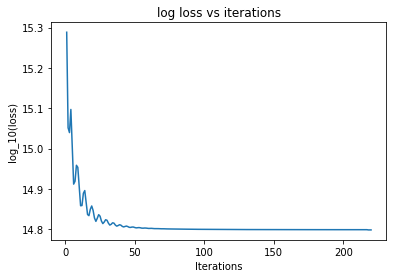

Not flipping kernel, as passed to torch.nn.functional.conv2d!
--- Finished in a total of 5.478649139404297 seconds ---


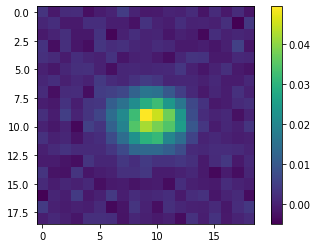

In [5]:
## DIA
G = 7.7
rdnoise = 10.5 / G
kernel_r, B0_r = PyTorchDIA_CCD.DIA(ref0 - np.median(ref0),
                                    y,
                                    np.ones(y.shape),
                                    rdnoise = rdnoise,
                                    G = G,
                                    ks = 19,
                                    lr_kernel = 1e-3,
                                    lr_B = 1e1,
                                    show_convergence_plots=True)

plt.imshow(kernel_r)
plt.colorbar();

--- Time to move data onto GPU: 0.0009410381317138672 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 500, 500]) torch.Size([1, 1, 500, 500]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 254 SD steps
Converged!
Total steps taken: 259
SD steps: 254
L-BFGS steps: 5
--- Finished kernel and background fit in 4.266676425933838 seconds ---
Photometric scaling: tensor(1.0916992426, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 57.0067138671875


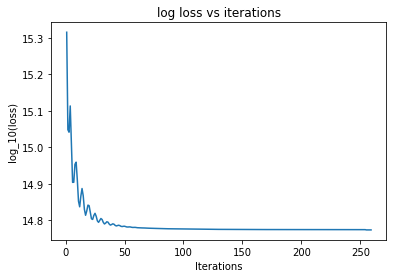

Not flipping kernel, as passed to torch.nn.functional.conv2d!
--- Finished in a total of 4.40822434425354 seconds ---


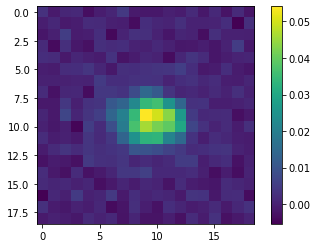

In [6]:
kernel_m, B0_m = PyTorchDIA_CCD.DIA(model - np.median(model),
                                    y,
                                    np.ones(y.shape),
                                    rdnoise = rdnoise,
                                    G = G,
                                    ks = 19,
                                    lr_kernel = 1e-3,
                                    lr_B = 1e1,
                                    show_convergence_plots=True)

plt.imshow(kernel_m)
plt.colorbar();

In [7]:
# predictions / models
kernel_size = 19
ref0, kernel_r = convert_to_tensor(ref0), convert_to_tensor(kernel_r)
model, kernel_m = convert_to_tensor(model), convert_to_tensor(kernel_m)

prediction_r = torch.nn.functional.conv2d(ref0 - torch.median(ref0), kernel_r,
                                          bias=None, padding=np.int(((kernel_size - 1)/2))) 
prediction_r += torch.tensor(B0_r)

prediction_m = torch.nn.functional.conv2d(model - torch.median(model), kernel_m,
                                          bias=None, padding=np.int(((kernel_size - 1)/2))) 
prediction_m += torch.tensor(B0_m)

In [8]:
# difference
y = convert_to_tensor(y)
D_r = y - prediction_r
D_m = y - prediction_m

In [9]:
## save results
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    
save_numpy_as_fits(D_r, 'D_r.fits')
save_numpy_as_fits(D_m, 'D_m.fits')

In [10]:
## sum of the squares
S_r = torch.sum(D_r**2)
S_m = torch.sum(D_m**2)
S_r, S_m

(tensor(46385600.), tensor(44401488.))

In [11]:
## ratio
S_m / S_r

tensor(0.9572256804)

In [12]:
## normalised_residuals
var_r = (rdnoise)**2 + (prediction_r / G)
var_m = (rdnoise)**2 + (prediction_m / G)

nr_r = D_r / torch.sqrt(var_r)
nr_m = D_m / torch.sqrt(var_m)

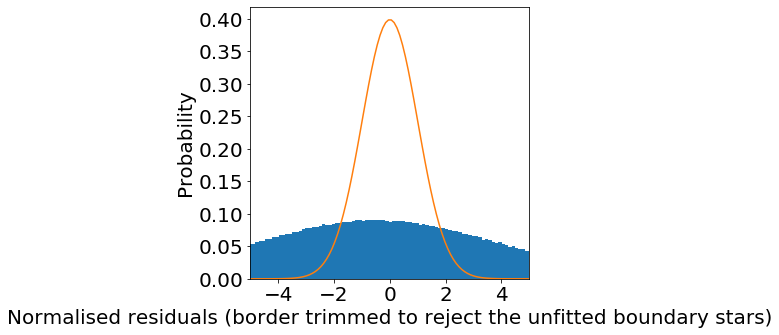

In [13]:
plt.figure(figsize=(5,5))
plt.hist(nr_r.numpy().flatten(), bins='auto', density=True)
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, 0, 1))
plt.xlim(-5, 5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Normalised residuals (border trimmed to reject the unfitted boundary stars)', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.show();

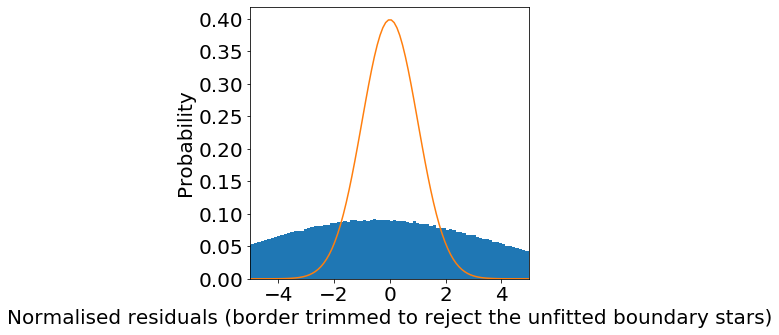

In [14]:
plt.figure(figsize=(5,5))
plt.hist(nr_m.numpy().flatten(), bins='auto', density=True)
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, 0, 1))
plt.xlim(-5, 5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Normalised residuals (border trimmed to reject the unfitted boundary stars)', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.show();

In [9]:
#### noise comparison - effect of light deconvolution kernel?
from astropy.stats import mad_std

model_file1 = '81_LCO_phik0_LaPlace_1e-1_L2grad_1e-8_pass0.fits'
model_file2 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-8_pass0.fits'
model_file3 = '81_LCO_phik1_L1_1e4_L2grad_1e-8_pass0.fits'
model_file4 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_pass0.fits'


model1 = fits.getdata(os.path.join('SceneEstimates', model_file1))
model2 = fits.getdata(os.path.join('SceneEstimates', model_file2))
model3 = fits.getdata(os.path.join('SceneEstimates', model_file3))
model4 = fits.getdata(os.path.join('SceneEstimates', model_file4))

In [10]:
mad_std(model1), mad_std(model2), mad_std(model3), mad_std(model4)

(15.428844003079154, 16.020133892377874, 16.33938139786547, 15.512843555995872)

In [12]:
np.min(model1), np.min(model2), np.min(model3), np.min(model4)

(-69.268166, -92.95279, -96.51423, -96.399994)

In [13]:
np.max(model1), np.max(model2), np.max(model3), np.max(model4)

(2754.441, 3007.4727, 2987.0188, 2973.1052)

In [15]:
np.median(model1), np.median(model2), np.median(model3), np.median(model4)

(-0.42784208, -0.4205417, -1.0887692, -0.35249403)

In [15]:
model_file1 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass0.fits'
model_file2 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass1.fits'
model_file3 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass2.fits'
model_file4 = '81_LCO_phik1_LaPlace_1e-1_L2grad_1e-5_clip_annealLR_pass3.fits'

model1 = fits.getdata(os.path.join('SceneEstimates', model_file1))
model2 = fits.getdata(os.path.join('SceneEstimates', model_file2))
model3 = fits.getdata(os.path.join('SceneEstimates', model_file3))
model4 = fits.getdata(os.path.join('SceneEstimates', model_file4))

In [16]:
mad_std(model1), mad_std(model2), mad_std(model3), mad_std(model4)

(14.291436129691082, 14.259717670020313, 14.294374254738818, 14.38114791802303)

In [17]:
np.min(model1), np.min(model2), np.min(model3), np.min(model4)

(-42.894375, -42.526947, -42.731167, -43.070923)

In [18]:
np.max(model1), np.max(model2), np.max(model3), np.max(model4)

(2426.303, 2480.0042, 2528.0667, 2572.2551)

In [19]:
np.median(model1), np.median(model2), np.median(model3), np.median(model4)

(-0.17030954, -0.13821594, -0.075441904, 0.02120888)

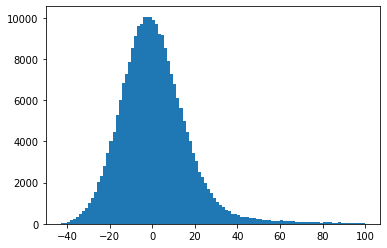

In [13]:
plt.hist(model1[model1 < 100], bins=100)[2];

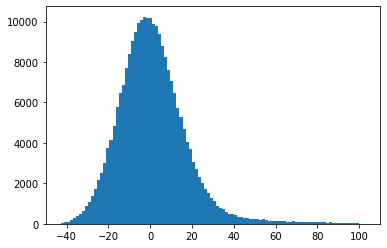

In [20]:
plt.hist(model3[model4 < 100], bins=100)[2];